In [1]:
from pylab import rcParams
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
# import numpy as np
import random as random
# import matplotlib.pyplot as plt
import time
import pandas as pd
import math
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import distance#
from pyproj import Proj,transform
import seaborn as sns
import copy
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import multiprocessing
from datetime import datetime
from scipy import stats
from scipy.stats import variation
import glob
from ipywidgets import *

%matplotlib notebook

# Read files: sentinel-3 data ESA 

### Precipitation 

In [90]:
Precip = pd.read_csv('radar_precipitation_location_2/precipitation.csv')
MA_rain = Precip['precipitation'].rolling(window=5, center = False).mean()

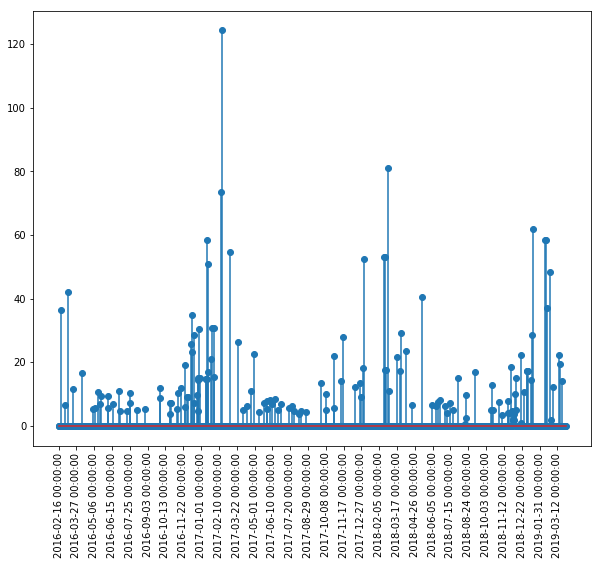

In [10]:
plt.figure(figsize = (10,8))
plt.stem(range(len(Precip)), Precip['precipitation'].values)
plt.xticks(np.arange(0,len(Precip), 40), Precip.loc[np.arange(0,len(Precip), 40),'date'].values , rotation = 90);

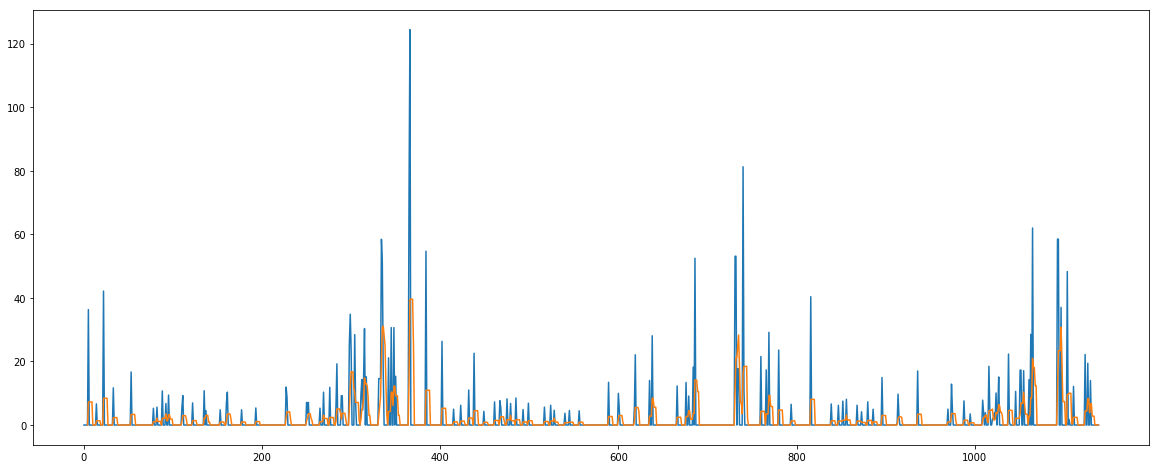

In [11]:
plt.figure(figsize = (20,8))
plt.plot(range(len(Precip)), Precip['precipitation'])
plt.plot(range(len(Precip)), MA_rain)

### waveforms

In [75]:
wave = pd.read_csv('radar_precipitation_location_2/waveforms.csv')

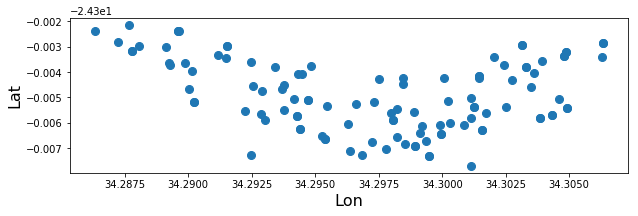

In [76]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(wave['lon'].values, wave['lat'].values, 'o',  ms = 8, label = '{} samples'.format(len(wave)))

plt.xlabel('Lon', fontsize = 16)
plt.ylabel('Lat', fontsize = 16)
ax.set_aspect('equal')

In [77]:
wave = wave.sort_values(by = ['time'])
wave = wave.reset_index()

In [78]:
#reformat days

# convert dates to week ends
date_format = "%Y-%m-%d %H:%M:%S"

def Spacing(Dates):
    day = []
    earliestDate = min(Precip['date'])
    earliestDate = datetime.strptime(earliestDate, date_format)
    for i in range(0, len(Dates)):
        try:
            d = datetime.strptime(Dates[i], "%Y-%m-%d %H:%M:%S.%f")
        except ValueError:
            d = datetime.strptime(Dates[i], "%Y-%m-%d %H:%M:%S")
        day.append((d-earliestDate).days) 
    return day

In [79]:
Precip['day'] = Spacing(Precip['date'])
wave['day'] = Spacing(wave['time'])

In [81]:
# wave

In [31]:
Samples = ['sample_{}'.format(a) for a in range(128)]
WaveForm = wave.loc[:, Samples]

In [32]:
PrecipWaveMatch = Precip.loc[wave['day'].values,'precipitation'].values


RainFall = wave[PrecipWaveMatch>0]
NoRain = wave[PrecipWaveMatch==0]


/home/emma/.local/lib/python3.5/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [47]:
wave['day'].values

array([  64,   72,   91,   99,  118,  126,  126,  145,  145,  153,  153,
        172,  172,  180,  180,  199,  199,  207,  207,  226,  226,  234,
        234,  253,  253,  261,  261,  280,  280,  288,  288,  307,  307,
        315,  315,  334,  334,  342,  342,  361,  361,  369,  369,  388,
        388,  396,  396,  415,  415,  423,  423,  442,  450,  469,  477,
        496,  504,  523,  531,  550,  558,  577,  585,  604,  612,  631,
        639,  658,  666,  685,  693,  712,  720,  739,  747,  766,  774,
        793,  801,  820,  828,  847,  847,  855,  874,  882,  882,  901,
        901,  909,  909,  928,  928,  936,  936,  955,  955,  963,  963,
        982,  990, 1009, 1017, 1036, 1044, 1063, 1071, 1090, 1098, 1117,
       1125, 1144, 1152])

In [107]:
PrecipWaveMatch_MA = MA_rain.loc[wave['day'].values].values
Previous5day = PrecipWaveMatch_MA[PrecipWaveMatch_MA>0]
Zero5day = PrecipWaveMatch_MA[PrecipWaveMatch_MA==0]
Wave5day = wave[PrecipWaveMatch_MA>0]
WaveZero5day = wave[PrecipWaveMatch_MA==0]
# MA_rain
# MA_rain.loc[wave['day'].values]>0
# MA_rain
# Previous5day = MA_rain[(MA_rain.loc[wave['day'].values]>0).values]
# Wave5day = wave[(MA_rain.loc[wave['day'].values]>0).values]

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [35]:
DatesRain =[ datetime.strptime(RainFall.loc[a, 'time'], "%Y-%m-%d %H:%M:%S.%f").date() for a in RainFall.index]


Text(0, 0.5, 'Power')

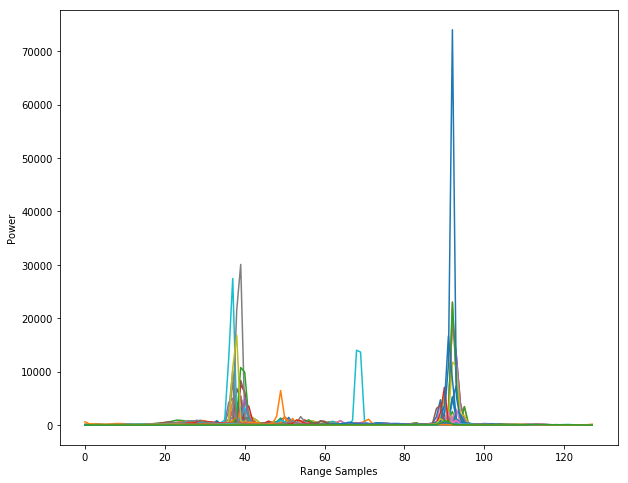

In [32]:
# all waves
plt.figure(figsize = (10,8))
for j in range(len(wave)):
    plt.plot(range(128), WaveForm.loc[j,:].values, label = 'Date = {},\nPrecipitation ={}'.format(datetime.strptime(wave.loc[j, 'time'], "%Y-%m-%d %H:%M:%S.%f").date(), PrecipWaveMatch[j]))
plt.xlabel('Range Samples')
plt.ylabel('Power')
# plt.legend(loc = 'upper right')

Text(0, 0.5, 'Power')

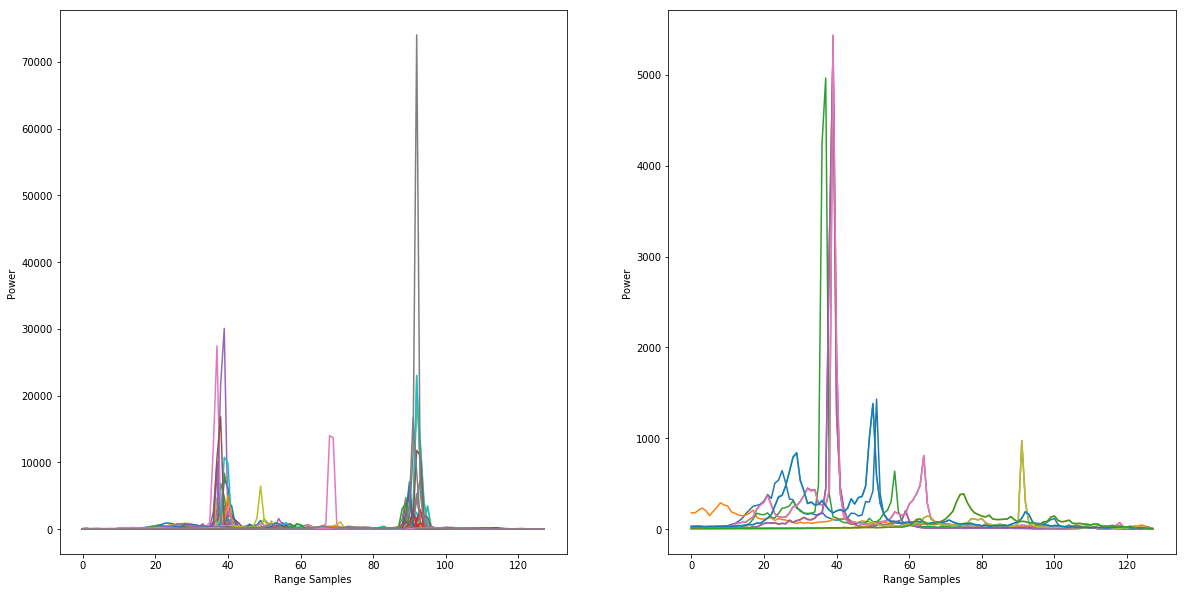

In [112]:
# when precipitation for previous 5 days is greater than zero
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
for index, j in enumerate(Wave5day.index):
    plt.plot(range(128), Wave5day.loc[j,Samples].values, label = 'Date = ,Precip ={}'.format( round(Previous5day[index],4)))
plt.xlabel('Range Samples')
plt.ylabel('Power')

plt.subplot(1,2,2)
for index, j in enumerate(WaveZero5day.index):
    plt.plot(range(128), WaveZero5day.loc[j,Samples].values, label = 'Date = ,Precip ={}'.format( round(Zero5day[index],4)))
plt.xlabel('Range Samples')
plt.ylabel('Power')
# plt.legend(ncol = 3)

Text(0, 0.5, 'Power')

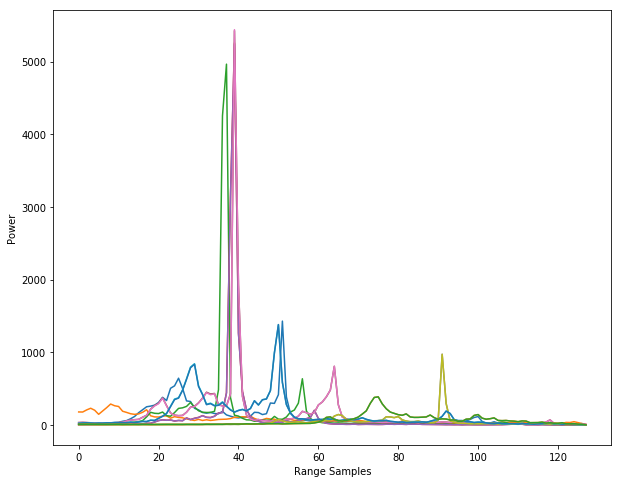

Text(0, 0.5, 'Power')

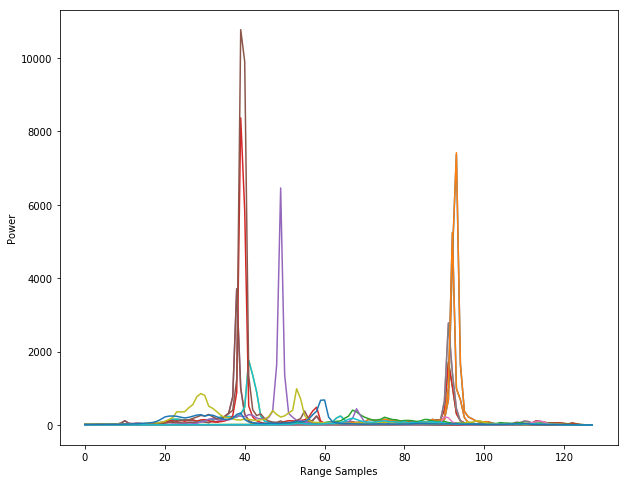

In [53]:
plt.figure(figsize = (10,8))
for index, j in enumerate(RainFall.index):
    plt.plot(range(128), RainFall.loc[j,Samples].values, label = 'Date = {},Precip ={}'.format(DatesRain[index], round(PrecipWaveMatch[j],4)))
plt.xlabel('Range Samples')
plt.ylabel('Power')
# plt.legend(ncol = 3)

No handles with labels found to put in legend.


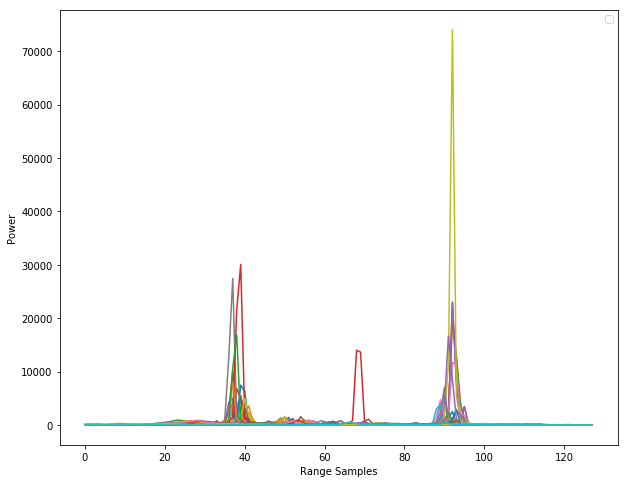

In [52]:
plt.figure(figsize = (10,8))
for index, j in enumerate(NoRain.index):
    plt.plot(range(128), NoRain.loc[j,Samples].values)
plt.xlabel('Range Samples')
plt.ylabel('Power')
plt.legend(ncol = 3)

In [47]:
window = 5
MA2 = WaveForm2.rolling(window=window, center = True, axis = 1).mean()

<IPython.core.display.Javascript object>


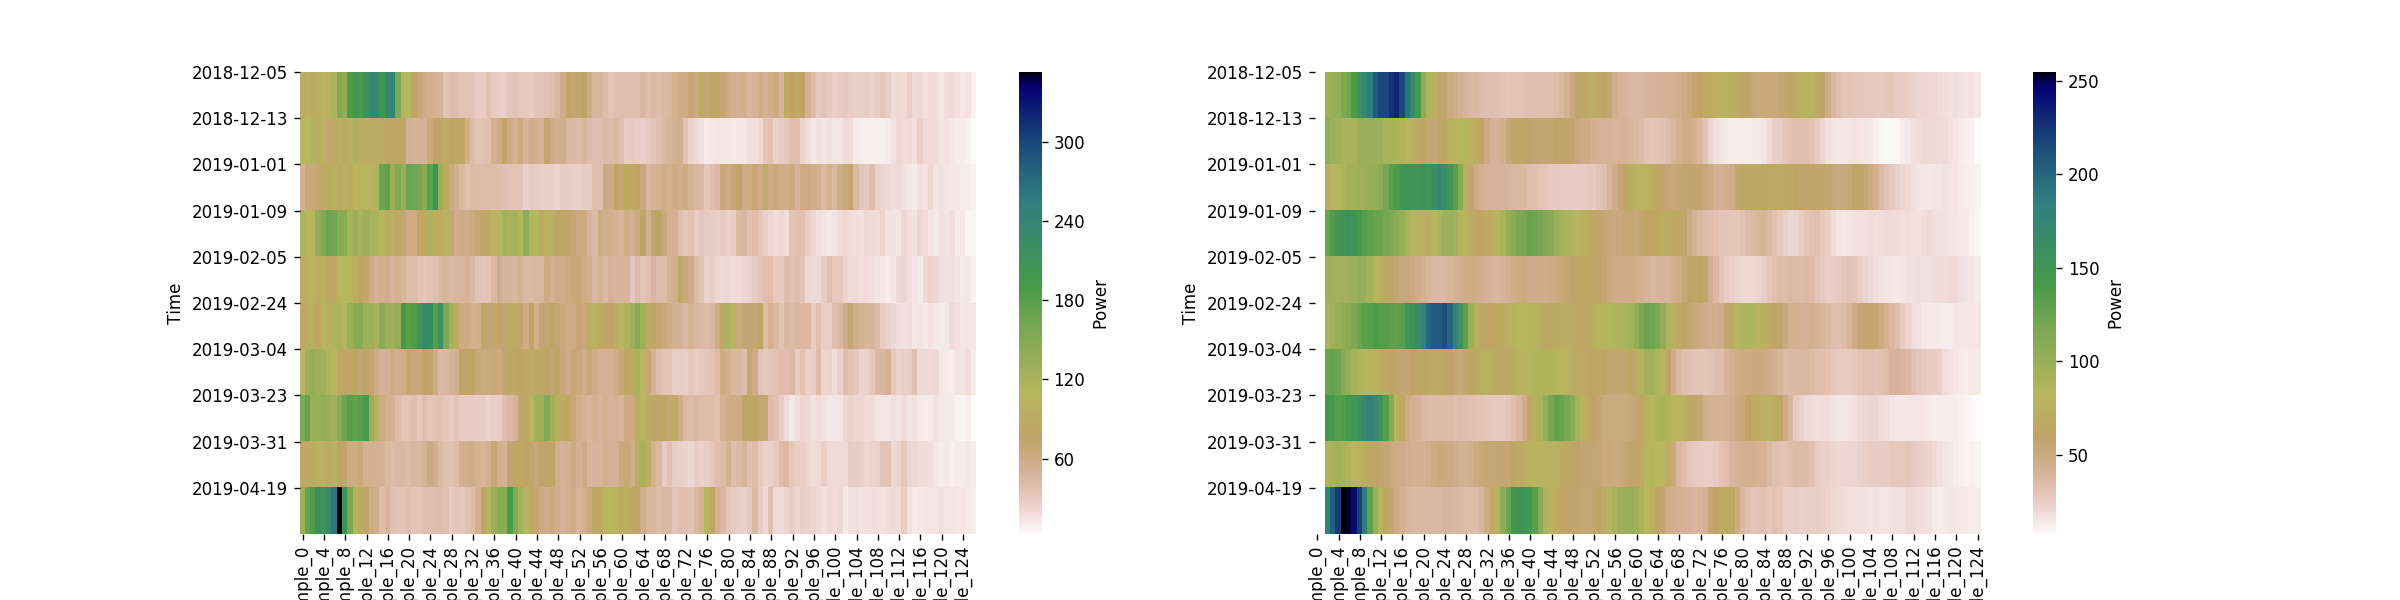

In [69]:
%matplotlib notebook
plt.figure(figsize = (20, 5))
plt.subplot(1,2,1)
sns.heatmap(WaveForm2,cmap = 'gist_earth_r', cbar_kws={'label': 'Power'})
plt.xlabel('Range Sample')
plt.ylabel('Time')
plt.yticks(range(10), Dates2, rotation = 0);

plt.subplot(1,2,2)
sns.heatmap(MA2, cmap = 'gist_earth_r', cbar_kws={'label': 'Power'})
plt.xlabel('Range Sample')
plt.ylabel('Time')
plt.yticks(range(10), Dates2, rotation = 0);


<IPython.core.display.Javascript object>


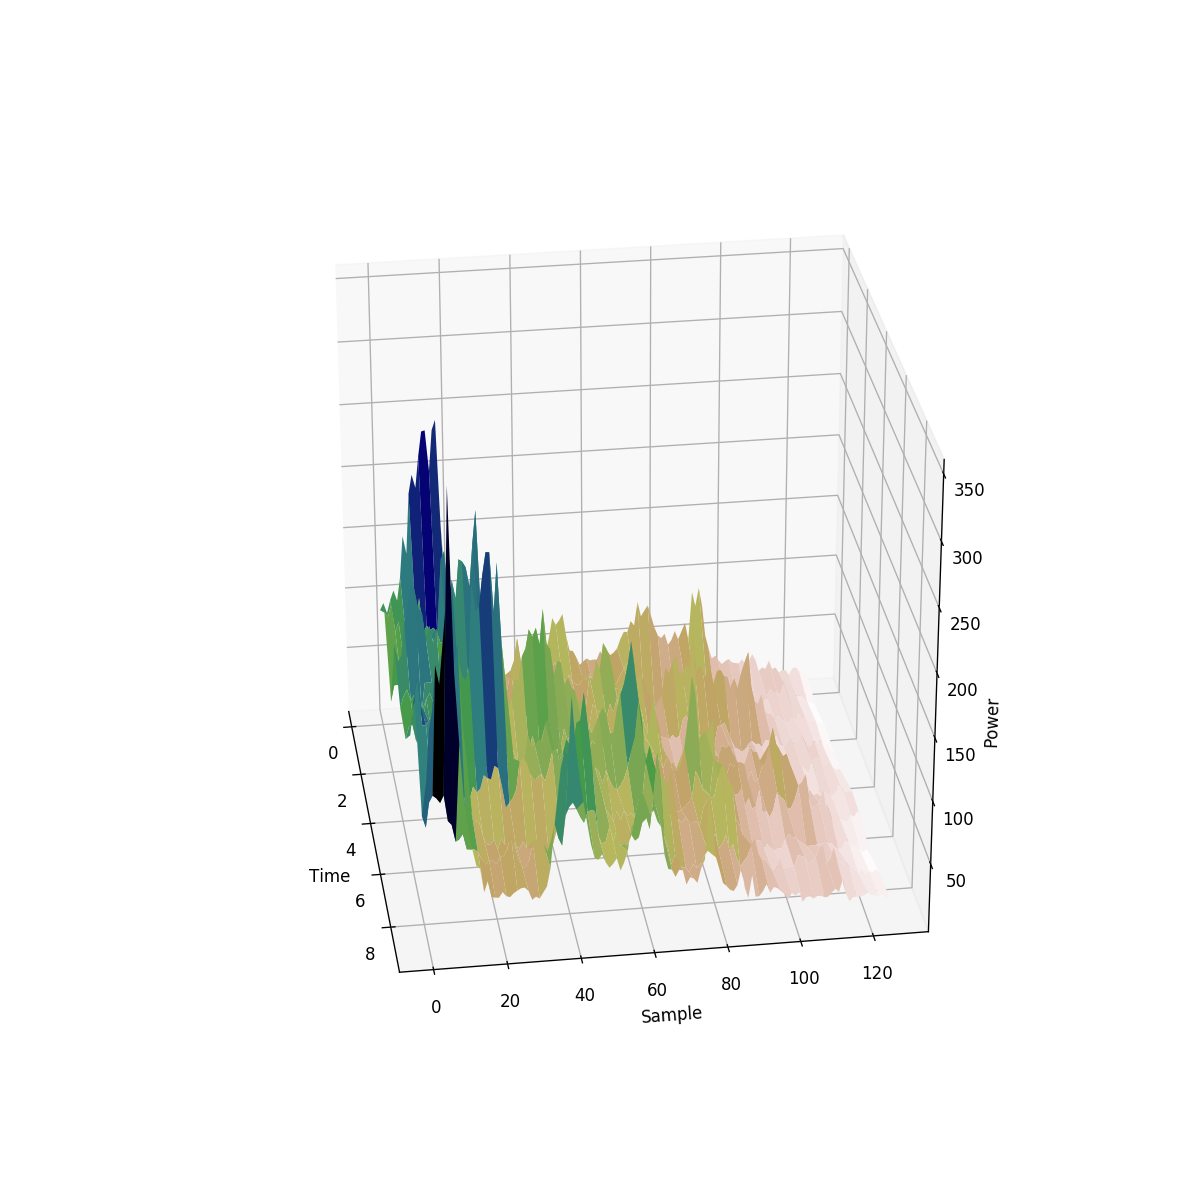

In [24]:
%matplotlib notebook
X =  WaveForm2.index
Y = range(len(WaveForm2.columns))
X, Y = np.meshgrid(X, Y)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
Z = WaveForm2.as_matrix()
ax.plot_surface(X, Y,Z.T,cmap = 'gist_earth_r', label = 'Power')
plt.xlabel('Time')
plt.ylabel('Sample')
ax.set_zlabel('Power')
plt.show()

In [17]:
cluster2['time']
# Precip['date']

0    2018-12-05 19:56:20.632342
1    2018-12-13 07:25:05.892468
2    2019-01-01 19:56:22.472501
3    2019-01-09 07:25:09.350459
4    2019-02-05 07:25:09.458407
5    2019-02-24 19:56:25.286113
6    2019-03-04 07:25:12.574116
7    2019-03-23 19:56:29.151410
8    2019-03-31 07:25:15.610574
9    2019-04-19 19:56:29.890484
Name: time, dtype: object

### Scaled data

(array([  -60.,   -30.,     0.,    30.,    60.,    90.,   120.,   150.,
          180.,   210.,   240.,   270.,   300.,   330.,   360.,   390.,
          420.,   450.,   480.,   510.,   540.,   570.,   600.,   630.,
          660.,   690.,   720.,   750.,   780.,   810.,   840.,   870.,
          900.,   930.,   960.,   990.,  1020.,  1050.,  1080.,  1110.,
         1140.,  1170.,  1200.]), <a list of 43 Text xticklabel objects>)

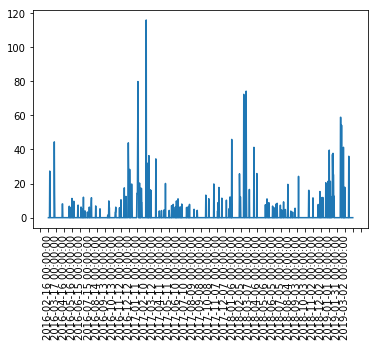

In [21]:
import matplotlib.ticker as ticker
tick_spacing = 30
fig, ax = plt.subplots(1,1)
ax.plot(Precip['date'].values, Precip['precipitation'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing),)
plt.xticks(rotation = 90)


In [29]:
len(Precip)

1140

<IPython.core.display.Javascript object>


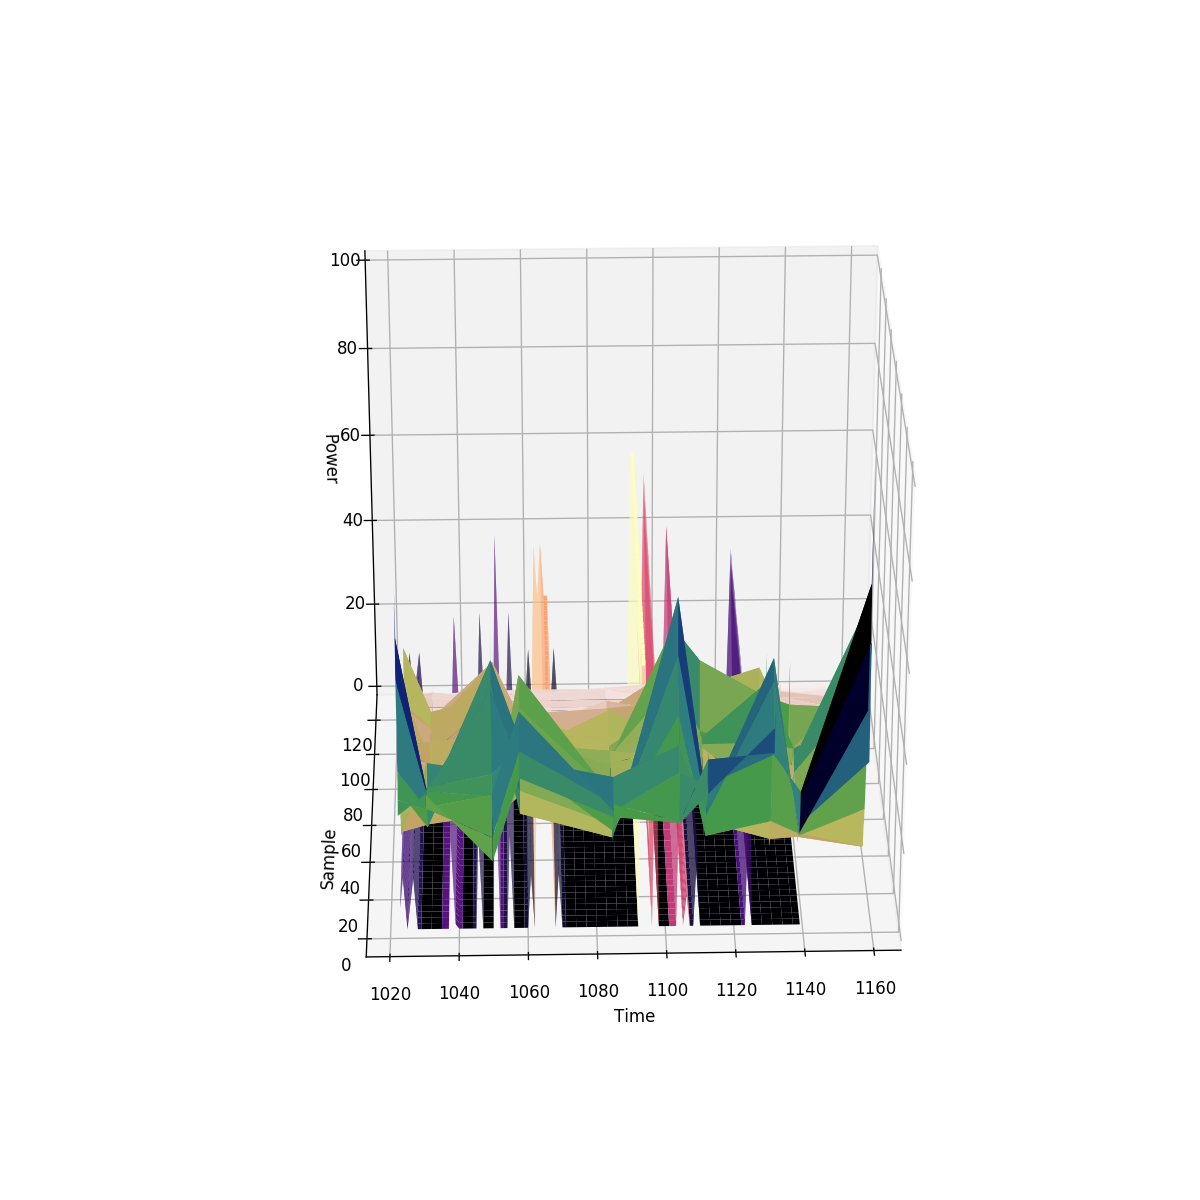

In [32]:
%matplotlib notebook
X_wave =  cluster2['day'].values
Y_wave = range(len(WaveForm2.columns))
X_wave, Y_wave = np.meshgrid(X_wave, Y_wave)
Y_precip =range(len(WaveForm2.columns))
X_precip = range(1023,1140)
# Precip['day'].values
X_precip, Y_precip = np.meshgrid(X_precip, Y_precip)

Z_precip = np.matrix([Precip.loc[1023:1140, 'precipitation'].values,]*len(WaveForm2.columns))
Z_wave = (WaveForm2.as_matrix()/(WaveForm2.as_matrix()).max())*100


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_wave, Y_wave,Z_wave.T,cmap = 'gist_earth_r', label = 'Power')
ax.plot_surface(X_precip, Y_precip,Z_precip,cmap = 'magma')

plt.xlabel('Time')
plt.ylabel('Sample')
ax.set_zlabel('Power')
plt.show()